In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/confidence

/alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/confidence


/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [79]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [80]:
IMAGE_SHAPE = (1000, 1000)
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.4

### Создадим агрегатор

In [81]:
from src.aggregate.base import Aggregator, ComposeClassifier
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.confidence import MaxConfidenceClassifier, ConfidenceClassifier
from src.aggregate.merge import UnionMerger

In [82]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/confidence

/alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/confidence


In [83]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1
CONFIDENCE_THRESHOLD = 0.9
YOLO_CONF = 0.3

In [84]:
minconf_classifier = ConfidenceClassifier(N_CLASSES, YOLO_CONF)
noborder_classifier = NoBorderClassifier(N_CLASSES, IMAGE_SHAPE)
threshold_classifier = ThresholdClassifier(N_CLASSES, INTEGRATE_THRESHOLD)
confidence_classifier = MaxConfidenceClassifier(N_CLASSES, CONFIDENCE_THRESHOLD)
classifier = ComposeClassifier([
    noborder_classifier,
    threshold_classifier,
])
merger = UnionMerger(N_CLASSES)
aggregator = Aggregator(classifier, merger)
gt_aggregator = Aggregator(threshold_classifier, merger)

### Интерполированный тест

In [85]:
import pickle
import json
TEST_NAME = 'dense'
with open(f'/alpha/projects/wastie/code/kondrashov/delta/notes/gt_test_24_09_dense_c03.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'/alpha/projects/wastie/code/kondrashov/delta/notes/pred_test_24_09_dense_c03.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

Median group size: 12


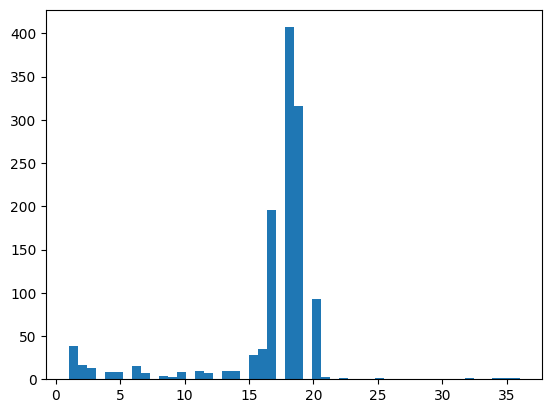

In [86]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [87]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [88]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [89]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

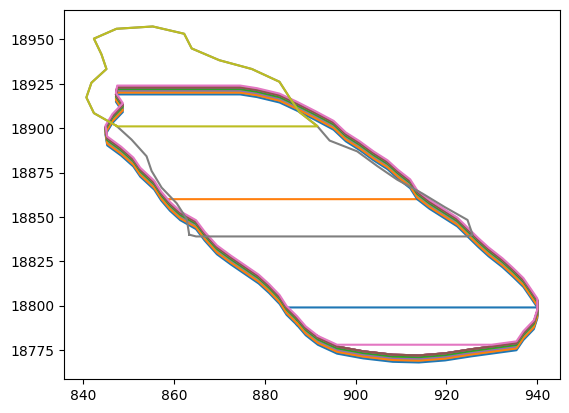

In [90]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Агрегация

In [91]:
gt = gt_aggregator.aggregate(gt_groups)
pred = aggregator.aggregate(pred_groups)

In [92]:
len(pred)

1515

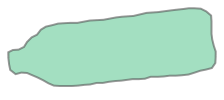

In [93]:
poly(gt[random.randint(0, len(gt))])

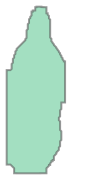

In [94]:
poly(pred[random.randint(0, len(pred))])

In [ ]:
# mismatch_set = set(map(int, mismatch_indices))

In [ ]:
# np.where(pred_matches2)[0]

array([  32,   34,   36,   43,   67,   75,   83,  105,  135,  142,  153,  167,  203,  216,  257,  261,  276,  283,  294,  324,  328,  367,  391,  394,  465,  495,  521,  536,  545,  551,  553,  572,  575,  582,  587,  634,  723,  767,  831,  853,  884,  903,  950,  997,  998, 1025, 1035, 1058, 1066, 1101, 1133, 1154,
       1157, 1167, 1183, 1213, 1215, 1238, 1251, 1271, 1341, 1347, 1351, 1406, 1414, 1422, 1448, 1458, 1466, 1487, 1488])

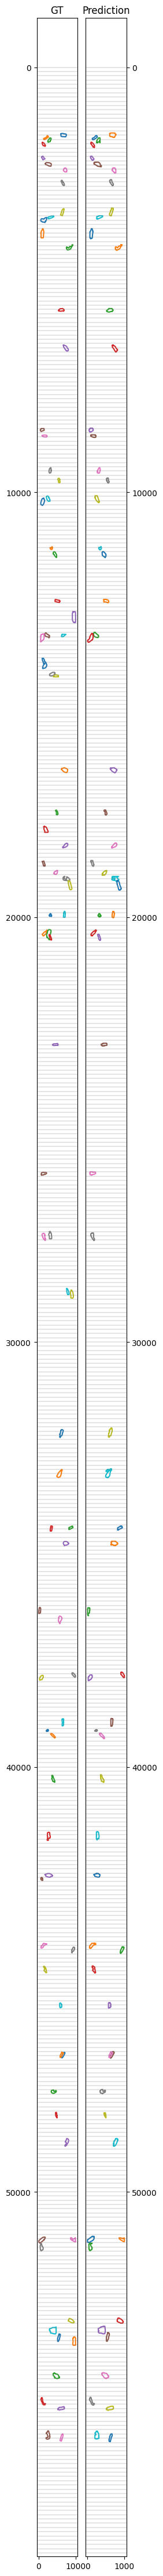

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, max(shifts.values()) / 1000))

for i, polygon in enumerate(map(poly, gt)):
    x, y = polygon.exterior.xy
    ax1.plot(x, y)
ax1.invert_yaxis()
ax1.set_title('GT')

for i, polygon in enumerate(map(poly, pred)):
    x, y = polygon.exterior.xy
    ax2.plot(x, y)
ax2.invert_yaxis()
ax2.set_title('Prediction')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

xlim = (min(ax.get_xlim()[0] for ax in [ax1, ax2]), max(ax.get_xlim()[1] for ax in [ax1, ax2]))
ylim = (min(ax.get_ylim()[0] for ax in [ax1, ax2]), max(ax.get_ylim()[1] for ax in [ax1, ax2]))

for ax in [ax1, ax2]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


min_ylim = 0
max_ylim = min(ax.get_ylim()[0] for ax in [ax1, ax2])
for ax in [ax1, ax2]:
    step = 100  # Draw line every 100 pixels
    for y in range(int(min_ylim), int(max_ylim), step):
        ax.axhline(y=y, color='gray', alpha=0.2, linestyle='-')

plt.show()

### Метрики

In [96]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.4):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

In [ ]:
# pred2 = gt_aggregator.aggregate(pred_groups)

In [ ]:
# len(pred2)

1734

In [ ]:
# pred_indices = np.where(pred_matches2)[0]

In [ ]:
# aggregated1 = gt_aggregator.aggregate([pred_groups[pred_indices[0]]])[0]
# aggregated2 = aggregator.aggregate([pred_groups[pred_indices[0]]])[0]

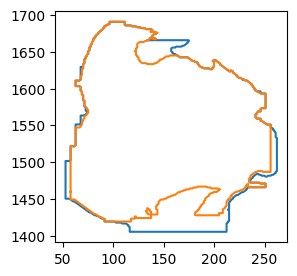

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# polygon = poly(aggregated1)
# x, y = polygon.exterior.xy
# ax.plot(x, y)

# polygon = poly(aggregated2)
# x, y = polygon.exterior.xy
# ax.plot(x, y)

# plt.show()

In [ ]:
# pred[pred_indices[70]], pred_indices[70]

({'points': array([[      601.9,       55764],
         [      601.9,       55765],
         [      601.9,       55768],
         [      601.9,       55772],
         [      601.9,       55776],
         [      601.9,       55786],
         [      601.9,       55787],
         [     600.65,       55789],
         [     600.65,       55790],
         [     600.65,       55790],
         [     595.65,       55795],
         [     595.65,       55797],
         [     595.65,       55797],
         [     594.41,       55799],
         [     594.41,       55800],
         [     593.16,       55801],
         [     593.16,       55802],
         [     591.91,       55804],
         [     591.91,       55805],
         [     591.91,       55806],
         [     590.66,       55807],
         [     590.66,       55810],
         [     590.66,       55810],
         [     586.91,       55810],
         [     586.91,       55821],
         [     586.91,       55823],
         [     585.66,      

In [97]:
gt_matches, pred_matches = find_matches(gt, pred)

  2%|███▌                                                                                                                                                | 30/1241 [00:00<00:10, 120.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:55<00:00, 22.40it/s]


In [ ]:
# gt_matches_backup = np.loadtxt("gt_matches.npy")
# pred_matches_backup = np.loadtxt("pred_matches.npy")

In [ ]:
# mismatch_indices = np.where(gt_matches_backup != gt_matches)[0]

In [ ]:
# print(len(mismatch_indices))

87


In [ ]:
# mask_iou(gt[mismatch_indices[1]], aggregated2)

0.00010873075734417324

In [ ]:
# np.mean(gt_matches[mismatch_indices].astype(int) * 2 - 1)

np.float64(0.632183908045977)

In [ ]:
# gt_matches2, pred_matches2 = find_matches([gt[i] for i in mismatch_indices], pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 23.31it/s]


In [ ]:
# for idx in mismatch_indices:
#     print(aggregator.aggregate([gt_groups[idx]]))
#     break

[{'points': array([[      601.9,      1570.7],
       [      601.9,      1571.7],
       [      601.9,      1607.6],
       [      601.9,      1608.6],
       [      601.9,      1609.6],
       [      601.9,      1610.6],
       [      601.9,      1611.6],
       [     603.15,      1612.9],
       [     603.15,      1613.4],
       [     603.15,      1614.4],
       [     603.15,      1615.4],
       [      604.4,      1616.6],
       [      604.4,      1616.9],
       [      604.4,      1617.9],
       [     608.14,      1621.6],
       [     608.14,      1621.9],
       [     608.14,      1622.9],
       [     610.64,      1625.3],
       [     611.89,      1625.3],
       [     614.39,      1627.8],
       [     616.88,      1627.8],
       [     618.13,      1629.1],
       [     623.13,      1629.1],
       [     624.38,      1630.3],
       [     638.11,      1630.3],
       [     639.36,      1631.6],
       [      648.1,      1631.6],
       [     649.35,      1632.8],
       [

In [102]:
precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5881
Recall: 0.7131
F1 Score: 0.6446


### Оптимальный порог интеграции

In [103]:
def find_best_threshold(gt_aligned_groups, pred_aligned_groups):
    thresholds = np.linspace(0.3, 0.95, 14)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        classifier = MaxConfidenceClassifier(N_CLASSES, threshold)
        merger = UnionMerger(N_CLASSES)
        aggregator = Aggregator(classifier, merger)
        
        pred = aggregator.aggregate(pred_groups)

        gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

        precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
        recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

In [104]:
#find_best_threshold(gt_aligned_groups, pred_aligned_groups)